Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams

import torch
from torch import nn, distributions, optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from tqdm import tqdm

import json

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.stats import norm

Seed, device, plot settings

In [3]:
# seed = np.random.randint(1, 10000)
# print(f"{seed}")

seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device.type.upper()}")

rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 100

Running on CUDA


RealNVP model

In [4]:
#en block
class RealNVPBlock(nn.Module):
    def __init__(self, in_features, hidden_features):
        super(RealNVPBlock, self).__init__()
        assert in_features % 2 == 0, "Input feature dimension must be even."
        self.in_features = in_features
        self.hidden_features = hidden_features

        self.net_s = self._build_network(in_features // 2, hidden_features)
        self.net_t = self._build_network(in_features // 2, hidden_features)

    def _build_network(self, in_features, hidden_features):
        return nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features * 2),
            nn.ReLU(),
            nn.Linear(hidden_features * 2, hidden_features * 2),
            nn.ReLU(),
            nn.Linear(hidden_features * 2, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, in_features),
        )

    def forward(self, x):
        x_a, x_b = x.chunk(2, dim=1)  # mora biti sodo
        s = self.net_s(x_a)
        t = self.net_t(x_a)
        y_a = x_a
        y_b = x_b * torch.exp(s) + t
        log_det_jacobian = s.sum(dim=1)
        return torch.cat([y_a, y_b], dim=1), log_det_jacobian

    def backward(self, y):
        y_a, y_b = y.chunk(2, dim=1)
        s = self.net_s(y_a)
        t = self.net_t(y_a)
        x_a = y_a
        x_b = (y_b - t) * torch.exp(-s)
        return torch.cat([x_a, x_b], dim=1)
    

# dejanski model
class RealNVP(nn.Module):
    def __init__(self, num_blocks, in_features, hidden_features):
        super(RealNVP, self).__init__()
        self.blocks = nn.ModuleList([RealNVPBlock(in_features, hidden_features) for _ in range(num_blocks)])
        self.prior = distributions.MultivariateNormal(torch.zeros(in_features).to(device), torch.eye(in_features).to(device))

    def forward(self, x):
        log_det_jacobian = 0
        for block in self.blocks:
            x, ldj = block.forward(x)
            log_det_jacobian += ldj
            x = torch.flip(x, dims=(1,))
        return x, log_det_jacobian

    def backward(self, y):
        for block in reversed(self.blocks):
            y = torch.flip(y, dims=(1,))
            y = block.backward(y)
        return y

    def log_prob(self, x):
        y, log_det_jacobian = self.forward(x)
        log_prob_z = self.prior.log_prob(y)
        return log_prob_z + log_det_jacobian

    def sample(self, batch_size):
        y = self.prior.sample((batch_size,))
        x = self.backward(y)
        return x

Nan checker

In [5]:
def check_for_nan(tensor, name=""):
    if torch.isnan(tensor).any():
        print(f"NaN detected in {name}")
        return True
    return False

Inicializacija uteži in dataseta

In [6]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

class CustomDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return torch.tensor(self.samples[idx], dtype=torch.float32)

### MAIN

podatki

In [7]:
with open('/home/fedja-mocnik/Documents/IJS_skripte/12d/data_parsed.json') as f:
    data = json.load(f)

vals = ["energy", "theta", "phi", "l", "b", "ra", "dec", "dEdXmax", "distXmax", "heightXmax", "xmax", "totalEnergy"]

#katerih najmanj
min_length = min(
    len(data['sdrec']['energy']),
    len(data['sdrec']['theta']),
    len(data['sdrec']['phi']),
    len(data['sdrec']['l']),
    len(data['sdrec']['b']),
    len(data['sdrec']['ra']),
    len(data['sdrec']['dec']),
    len(data['fdrec']['dEdXmax']),
    len(data['fdrec']['distXmax']),
    len(data['fdrec']['heightXmax']),
    len(data['fdrec']['xmax']),
    len(data['fdrec']['totalEnergy'])
)
print(f"minlen: {min_length}")

data_values = np.array([
    data['sdrec']['energy'][:min_length],
    data['sdrec']['theta'][:min_length],
    data['sdrec']['phi'][:min_length],
    data['sdrec']['l'][:min_length],
    data['sdrec']['b'][:min_length],
    data['sdrec']['ra'][:min_length],
    data['sdrec']['dec'][:min_length],
    data['fdrec']['dEdXmax'][:min_length],
    data['fdrec']['distXmax'][:min_length],
    data['fdrec']['heightXmax'][:min_length],
    data['fdrec']['xmax'][:min_length],
    data['fdrec']['totalEnergy'][:min_length]
]).T

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_values)

dataset = CustomDataset(data_scaled)

minlen: 1565


Split + dataloader

In [7]:
torch.manual_seed(seed)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_data_scaled = torch.utils.data.Subset(data_scaled, train_dataset.indices)
val_data_scaled = torch.utils.data.Subset(data_scaled, val_dataset.indices)
test_data_scaled = torch.utils.data.Subset(data_scaled, test_dataset.indices)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# PAZI data_scaled je Pytorch subset potrebujemo tensor
tds_tensor = torch.stack([torch.tensor(x) for x in test_data_scaled])  # vsak mora biti tensor

# pytorch -> numpy tenzor
tds_tensor = tds_tensor.numpy()

Hyperparameters + optim

In [8]:
dim = data_scaled.shape[1]  
num_blocks = 8 
hidden_features = 256
learning_rate = 1e-4
num_epochs = 200
visualize_epochs = [1, 100, 150]

model = RealNVP(num_blocks, dim, hidden_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Train function

In [9]:
def train_real_nvp(model, train_loader, val_loader, optimizer, scheduler, num_epochs, visualize_epochs, num_samples, patience, min_delta):
    best_val_loss = float('inf')
    best_model_weights = None
    train_loss_list = []
    val_loss_list = []
    epochs_without_improvement = 0  

    for epoch in range(num_epochs):
        
        model.train()
        train_loss = 0.0
        for x in train_loader:
            x = x.to(device)
            
            # fiksiranje log_prob
            x = torch.clamp(x, min=-10, max=10)
            
            optimizer.zero_grad()
            loss = -model.log_prob(x).mean()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x in val_loader:
                x = x.to(device)
                
                #fiksiranje vrednosti
                x = torch.clamp(x, min=-10, max=10)
                
                val_loss_batch = -model.log_prob(x).mean()
                val_loss += val_loss_batch.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # kakšna je izboljšava
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()
            epochs_without_improvement = 0  # resetiramo, če ni izboljšanja
        else:
            epochs_without_improvement += 1  # +1 če ni izboljšanja

        # early stopping, če se ni izboljšal
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    model.load_state_dict(best_model_weights)
    torch.save(model.state_dict(), "best_realnvp_model.pth")

    return train_loss_list, val_loss_list


Poženi

In [10]:
#pri rand je patience cca 10, 42 -> 28
train_loss, val_loss = train_real_nvp(model, train_loader, val_loader, optimizer, scheduler, num_epochs, visualize_epochs, num_samples=2048, patience=12, min_delta=1e-4)

Epoch 1/200, Training Loss: 16.9852, Validation Loss: 16.0794
Epoch 2/200, Training Loss: 16.2810, Validation Loss: 15.7378
Epoch 3/200, Training Loss: 15.7379, Validation Loss: 15.4432
Epoch 4/200, Training Loss: 15.3566, Validation Loss: 15.1778
Epoch 5/200, Training Loss: 14.8536, Validation Loss: 14.6878
Epoch 6/200, Training Loss: 14.1943, Validation Loss: 13.9372
Epoch 7/200, Training Loss: 13.4126, Validation Loss: 12.9704
Epoch 8/200, Training Loss: 12.4373, Validation Loss: 12.0796
Epoch 9/200, Training Loss: 11.5772, Validation Loss: 11.3419
Epoch 10/200, Training Loss: 10.8760, Validation Loss: 10.7642
Epoch 11/200, Training Loss: 10.4045, Validation Loss: 10.2640
Epoch 12/200, Training Loss: 9.7183, Validation Loss: 9.7784
Epoch 13/200, Training Loss: 9.1929, Validation Loss: 9.5907
Epoch 14/200, Training Loss: 8.8330, Validation Loss: 9.0441
Epoch 15/200, Training Loss: 8.4257, Validation Loss: 8.6603
Epoch 16/200, Training Loss: 8.1736, Validation Loss: 8.6867
Epoch 17/20

### EVAL

Plot Loss function

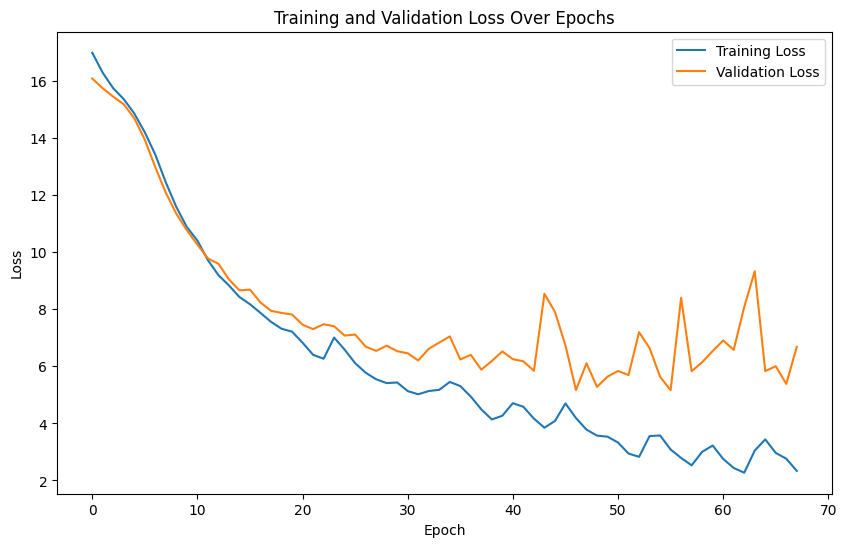

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Overlap function + risanje za visoko dim podatke

In [12]:
def compute_data_overlap(original_samples, generated_samples, bandwidth='scott'):
    """
    Computes the probability of overlap between original and generated samples.

    Parameters:
    - original_samples (torch.Tensor): Tensor of original data samples.
    - generated_samples (torch.Tensor): Tensor of generated data samples.
    - bandwidth (str or float): The bandwidth of the kernel. 'scott' or 'silverman' can be used for automatic selection, or specify a float value.

    Returns:
    - overlap_probability (float): The computed probability of overlap between the original and generated samples.
    """
    # Convert samples to numpy for KDE
    original_samples_np = original_samples.T
    generated_samples_np = generated_samples.T

    # Ensure both arrays have the same number of samples by sampling the smaller set
    min_samples = min(original_samples_np.shape[1], generated_samples_np.shape[1])
    original_samples_np = original_samples_np[:, np.random.choice(original_samples_np.shape[1], min_samples, replace=False)]
    generated_samples_np = generated_samples_np[:, np.random.choice(generated_samples_np.shape[1], min_samples, replace=False)]

    # Create KDEs for both distributions
    kde_original = gaussian_kde(original_samples_np, bw_method=bandwidth)
    kde_generated = gaussian_kde(generated_samples_np, bw_method=bandwidth)

    # Evaluate the KDEs over the same grid
    sample_points = np.hstack([original_samples_np, generated_samples_np])

    original_density = kde_original(sample_points)
    generated_density = kde_generated(sample_points)

    # Compute overlap as the minimum density at each point
    overlap_density = np.minimum(original_density, generated_density)

    # Integrate the overlap density to get the total overlap probability
    overlap_probability = np.sum(overlap_density) / np.sum(kde_original(sample_points))

    return overlap_probability

In [13]:
def plot_samples_overlap(original_samples, generated_samples):
    vals = ["energy", "theta", "phi", "l", "b", "ra", "dec", "dEdXmax", "distXmax", "heightXmax", "xmax", "totalEnergy"]

    num_features = original_samples.shape[1]
    fig, axs = plt.subplots(1, num_features, figsize=(5 * num_features, 5))
    
    if num_features == 1:
        axs = [axs]
    
    for i in range(num_features):
        kde_original = gaussian_kde(original_samples[:, i])
        x_range_original = np.linspace(original_samples[:, i].min(), original_samples[:, i].max(), 1000)
        
        kde_generated = gaussian_kde(generated_samples[:, i])
        x_range_generated = np.linspace(generated_samples[:, i].min(), generated_samples[:, i].max(), 1000)
        
        axs[i].plot(x_range_original, kde_original(x_range_original), label='Original', color='blue')
        axs[i].plot(x_range_generated, kde_generated(x_range_generated), label='Generated', color='red', linestyle='--')
        
        axs[i].set_title(f'{vals[i]}')
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Density')
        axs[i].legend()
    
    plt.suptitle(f'Original vs Generated Sample Distributions at Final Epoch')
    plt.tight_layout()
    plt.savefig(f'samples_comparison_epoch_final.png')
    plt.show()
    plt.close()

Izpisi 

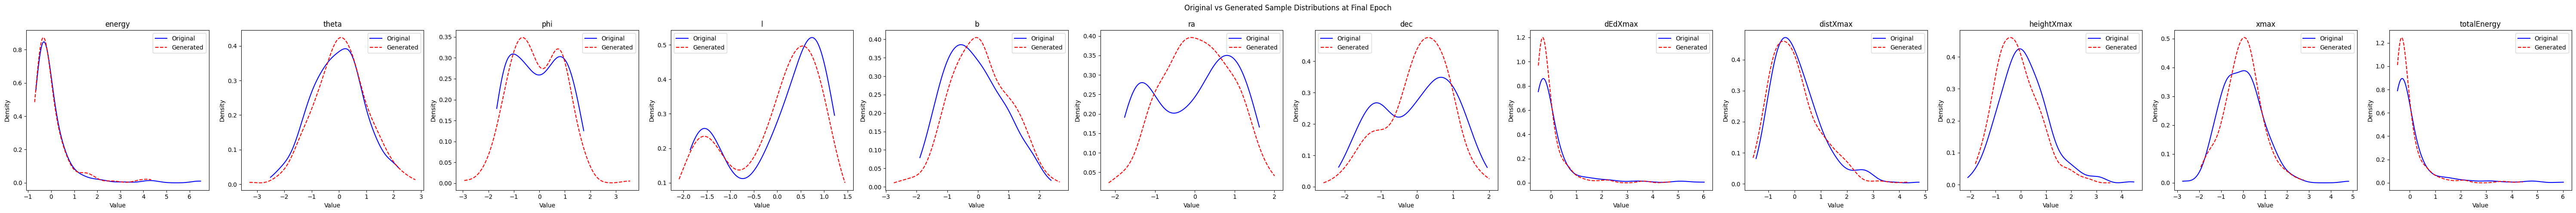

In [14]:
model.eval()
with torch.no_grad():
    generated = model.sample(len(test_dataset)).cpu()

    original = torch.stack([test_dataset[i] for i in range(len(test_dataset))])
    plot_samples_overlap(original, generated)

In [15]:
# model.eval()
# array_prob = []

# for i in range(800):
#     with torch.no_grad():
#         generated_samples = model.sample(len(test_dataset)).cpu()

#         # Overlap
#         original_samples = torch.stack([test_dataset[i] for i in range(len(test_dataset))])
#         array_prob.append(compute_data_overlap(original_samples, generated_samples))


# hist, bins = np.histogram(array_prob, bins=20)
# mean = np.mean(array_prob)
# std = np.std(array_prob)

# plt.stairs(hist, bins, linewidth=1.5)
# plt.legend(title=fr'mean = {np.round(mean,3)},$\sigma$ = {np.round(std, 3)}')
# plt.vlines(mean, ymin=0, ymax=100, colors="orange")

# print(np.max(array_prob))

In [16]:
def inverse_transform_generate(model, num_samples, dim):
    """
    Generate data using the inverse of the RealNVP model starting from a Gaussian distribution.
    
    Parameters:
    - model (RealNVP): The trained RealNVP model.
    - num_samples (int): Number of samples to generate.
    - dim (int): The dimensionality of the data.
    
    Returns:
    - generated_samples (np.array): Array of generated samples.
    """
    with torch.no_grad():
        # normalna distribucija
        z = torch.randn(num_samples, dim).to(device) #a je tukaj random kul?
        
        # inverz modela, da dobimo zeleno
        generated_samples = model.backward(z).cpu().numpy()
    
    return generated_samples

In [17]:
def plot_histogram_overlap(original_data, generated_data, vals, bins=18):
    """
    Plot overlapping histograms of original and generated data with sqrt(n) error bars for the original data.
    
    Parameters:
    - original_data (np.array): Original data from the dataset.
    - generated_data (np.array): Data generated by the model.
    - vals (list of str): List of labels for each feature.
    - bins (int): Number of bins to use for histograms.
    """

    vals = ["energy", "theta", "phi", "l", "b", "ra", "dec", "dEdXmax", "distXmax", "heightXmax", "xmax", "totalEnergy"]

    num_features = 12 #original_data.shape[1]
    fig, axs = plt.subplots(1, num_features, figsize=(5 * num_features, 5), constrained_layout=True)
    
    if num_features == 1:
        axs = [axs]
    
    for i in range(num_features):
        # Originalni + 
        counts, bin_edges = np.histogram(original_data[:, i], bins=bins, density=True, range=(np.min(generated_data[:,i]), np.max(generated_data[:,i])))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        errors = np.sqrt(counts / len(original_data))  # sqrt(n) error bars
        axs[i].errorbar(bin_centers, counts, yerr=errors, fmt='o', label='Original (with errors)', color='blue')

        # Histogrami za generirane
        axs[i].hist(generated_data[:, i], bins=bins, density=True, alpha=0.6, label='Generated', color='orange')
        
        axs[i].set_title(f'{vals[i]}')
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Density')
        axs[i].legend()

    plt.suptitle('Original vs Generated Data Overlap')
    plt.savefig(f"overlap_histograms.png")
    plt.show()

In [18]:
num_samples = len(tds_tensor)
generated_data = inverse_transform_generate(model, num_samples, dim)

Final probability of 12D data overlap: 0.3818


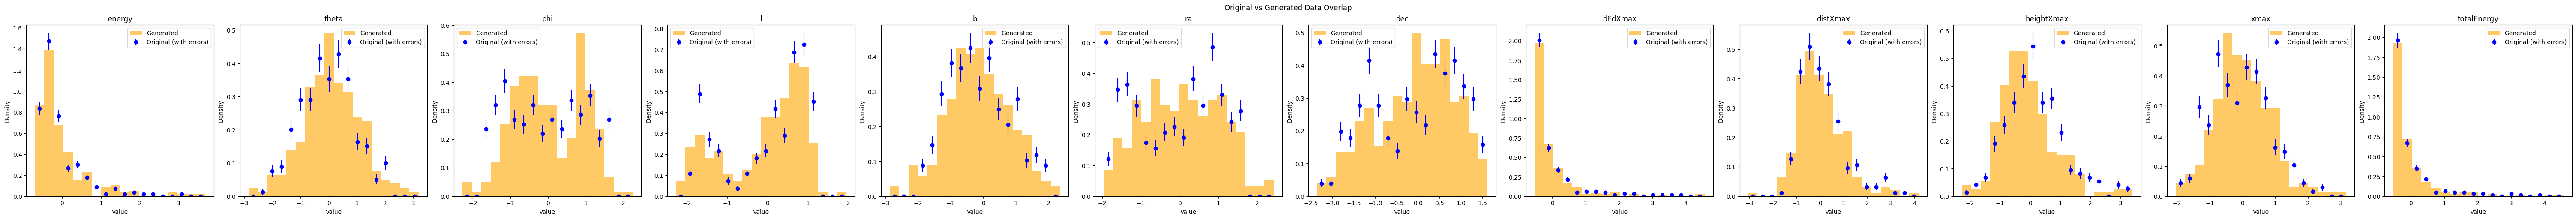

In [19]:
overlap_probability_12d = compute_data_overlap(tds_tensor, generated_data)
print(f"Final probability of 12D data overlap: {overlap_probability_12d:.4f}")

plot_histogram_overlap(tds_tensor, generated_data, vals)